# Advanced Lane Finding

The goal of this project is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car.

## Initialization

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle
import glob
%matplotlib inline

## Camera calibration

In this section, I Compute the camera calibration matrix and distortion coefficients given a set of chessboard images. First, I define the number of inside corners in x and in y as 9 and 6 respectively. Then, I import the set of chessboard images and call the find_corners function that returns the object and image points lists from the chessboard images. The find_corners function uses cv2.findChessboardCorners in each image to find the image points. The same object points array is replicated in object points list, once I assume the chessboard is fixed on the (x, y) plane at z=0.

Finally, I call the function cal_undistort that receives the objpoints and imgpoints and calculate the calibration matrix and distortion coefficients of the camera using the function cv2.calibrateCamera. So, I use the cv2.undistort function to apply this calibration and distortion correction to a test image and the result is shown in the image bellow.

In [2]:
def find_corners(images,nx,ny):
    '''
    images: list of images 
    nx: the number of inside corners in x
    ny: the number of inside corners in y
    return object and image points lists
    '''
    objp = np.zeros((nx*ny,3),np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
        
        
    return objpoints,imgpoints

def cal_undistort(img, objpoints, imgpoints):
    '''
    img: input image
    objpoints: list of 3d points in real world space
    imgpoints: list of 2d points in image plane 
    return undistorted image, camera matrix, distortion coeficient
    '''
    
    # convert to gray
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #Camera calibration, given object points, image points, and the shape of the grayscale image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    #Undistorting a image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
        
        
    return undist, mtx, dist





In [3]:
nx = 9 # number of inside corners in x
ny = 6 # number of inside corners in y
images=glob.glob('camera_cal/calibration*.jpg') # list of chessboard images

In [4]:
#Finding chessboard corners
objpoints, imgpoints = find_corners(images,nx,ny)

In [5]:
#test image
test_img = mpimg.imread('camera_cal/calibration1.jpg')
# Undistorting a test image
undistorted,mtx,dist = cal_undistort(test_img,objpoints,imgpoints)


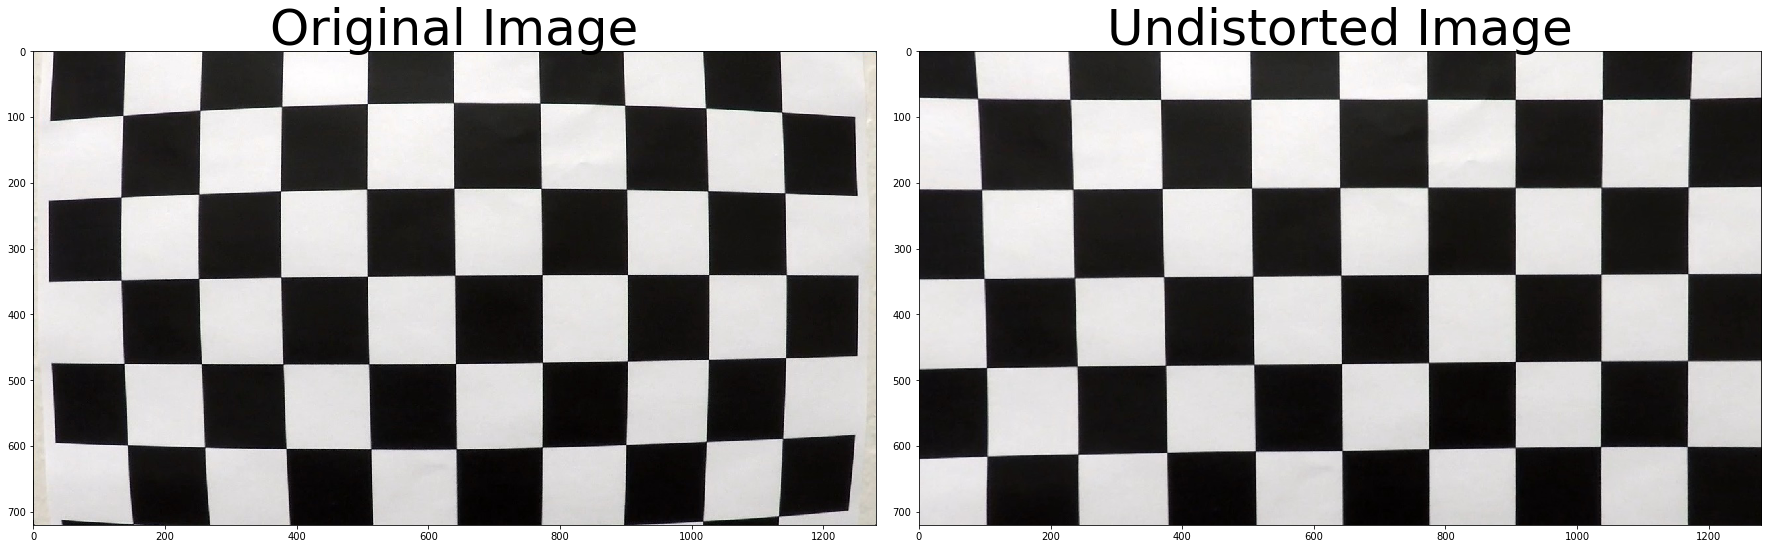

In [6]:
#plot test and undisorted images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.imsave("output_images/undistorted_chess.jpg",undistorted)

## Pipeline (single images)

### Distortion correction

In [421]:
#load test image
img = cv2.imread('test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Undistorting a test image
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

In the first step of my pipeline, I applied the function x to one of the test images. The undistorted image result is shown below.

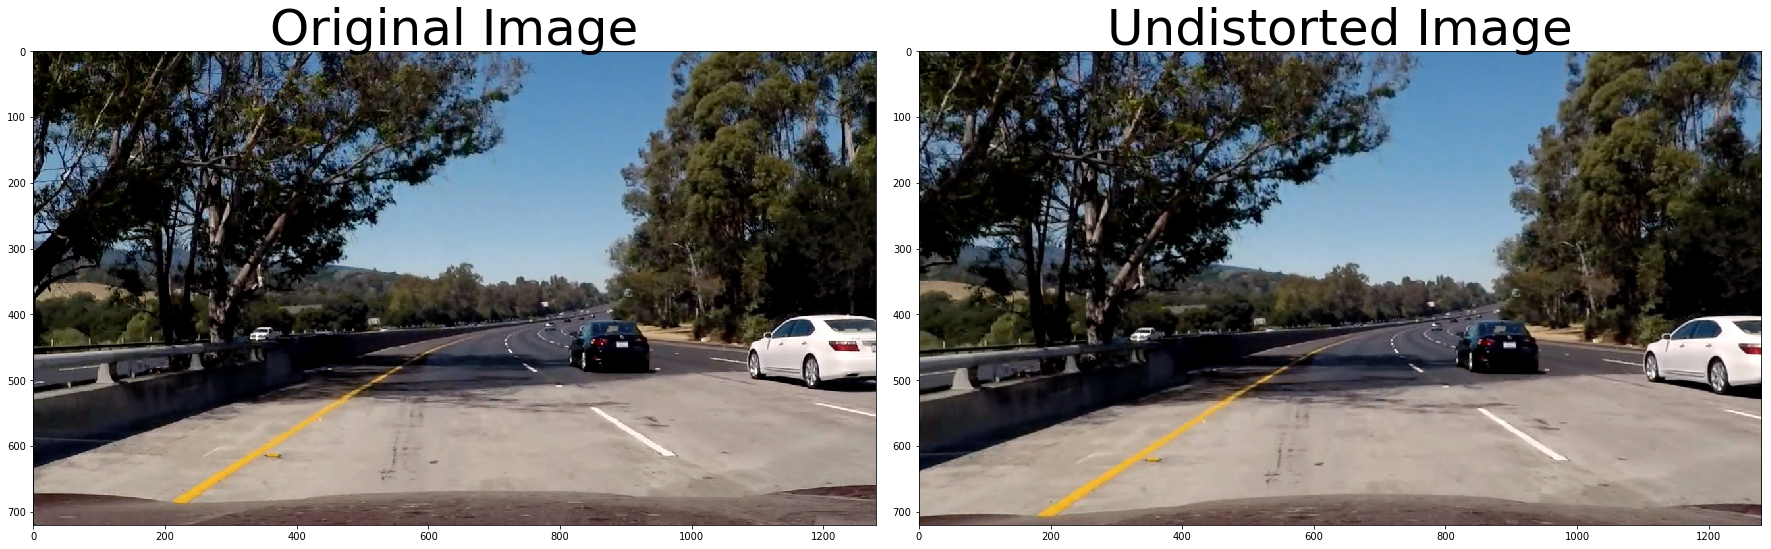

In [422]:
#plot test and undisorted images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.imsave("output_images/undistorted_test.jpg",undistorted)

### Binary image

In [423]:
def abs_sobel_thresh(img, sobel_kernel=3 , orient='x', thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def hls_select(img, thresh=(0, 255),ch=2):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    channel = hls[:,:,ch]
    binary_output = np.zeros_like(channel)
    binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary_output



In [424]:
#kernel size
ksize=3
gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=ksize, thresh=(25, 250))

s_bin = hls_select(undistorted,thresh=(200,230))

l_bin = hls_select(undistorted,thresh=(198,255),ch=1)

combined = np.zeros_like(s_bin)

combined[ (gradx == 1) | (s_bin == 1)| (l_bin == 1) ] = 1

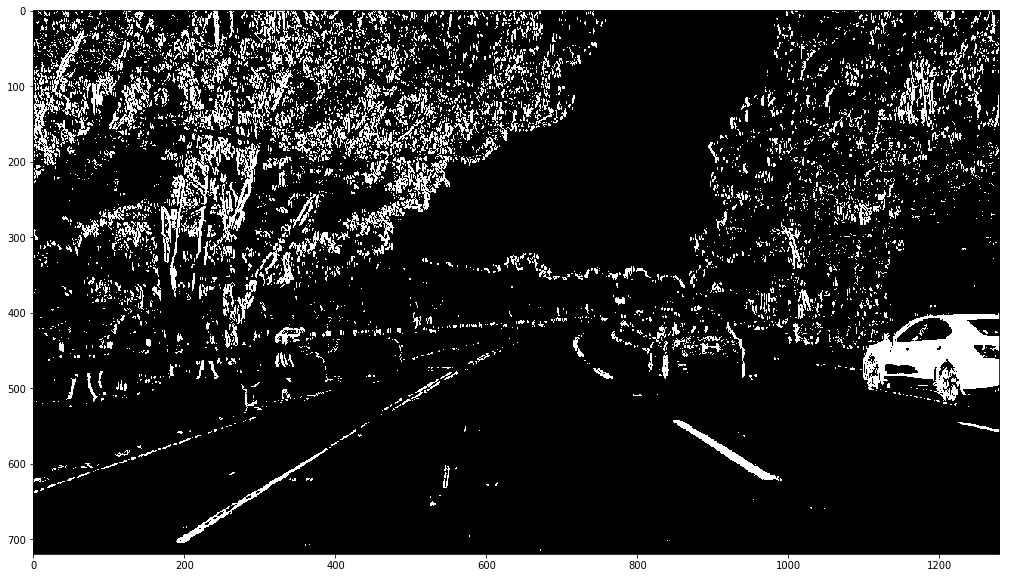

In [425]:
plt.figure(figsize=(20,10))
plt.imshow(combined,cmap='gray')

### Perspective transformation

In [408]:
def unwarp(img,src,dst):
    '''
    function corners_unwarp from the lesson Camera Calibration
    img: input image
    '''
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv
    

In [409]:
src = np.array([
        [img.shape[1] * 0.6, img.shape[0] * 0.65],
        [img.shape[1]*0.94, img.shape[0]],
        [img.shape[1]*0.09, img.shape[0]],
        [img.shape[1] * 0.44, img.shape[0] * 0.65],
    ],dtype='float32')

# Destination coordinates
dst = np.array([
        [img.shape[1] * 0.8, 0],
        [img.shape[1] * 0.8, img.shape[0]],
        [img.shape[1] * 0.2, img.shape[0]],
        [img.shape[1] * 0.2, 0],
    ],dtype='float32')



In [410]:
src

array([[  768.        ,   468.        ],
       [ 1203.19995117,   720.        ],
       [  115.19999695,   720.        ],
       [  563.20001221,   468.        ]], dtype=float32)

In [411]:
dst

array([[ 1024.,     0.],
       [ 1024.,   720.],
       [  256.,   720.],
       [  256.,     0.]], dtype=float32)

In [412]:

warped,M,Minv = unwarp(combined,src,dst)

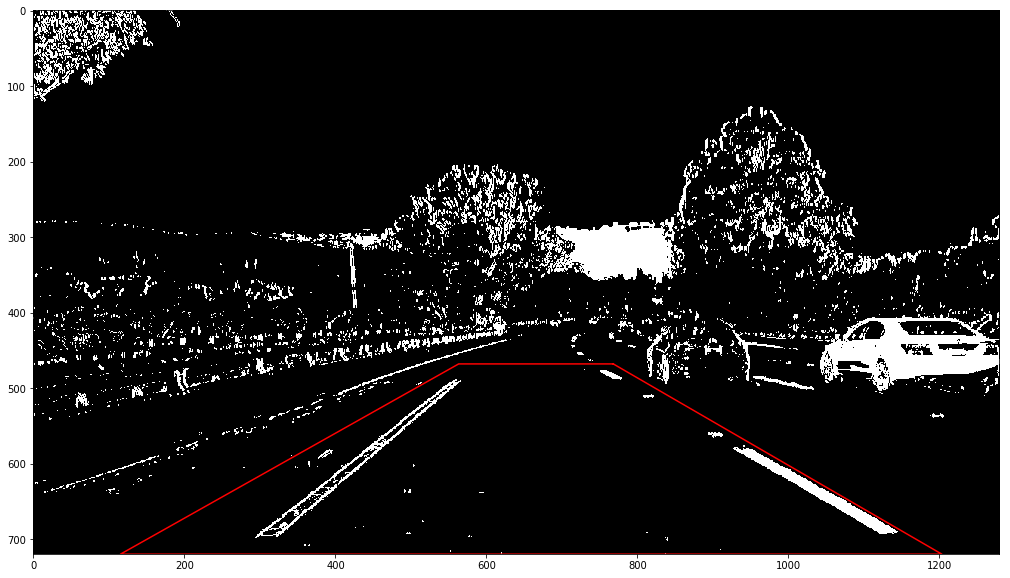

In [413]:
plt.figure(figsize=(20,10))
x = list(src[:,0])
y = list(src[:,1]) 
x.append(src[0,0])
y.append(src[0,1])
plt.plot(x, y, 'r-')
plt.imshow(combined,cmap='gray')
plt.show()

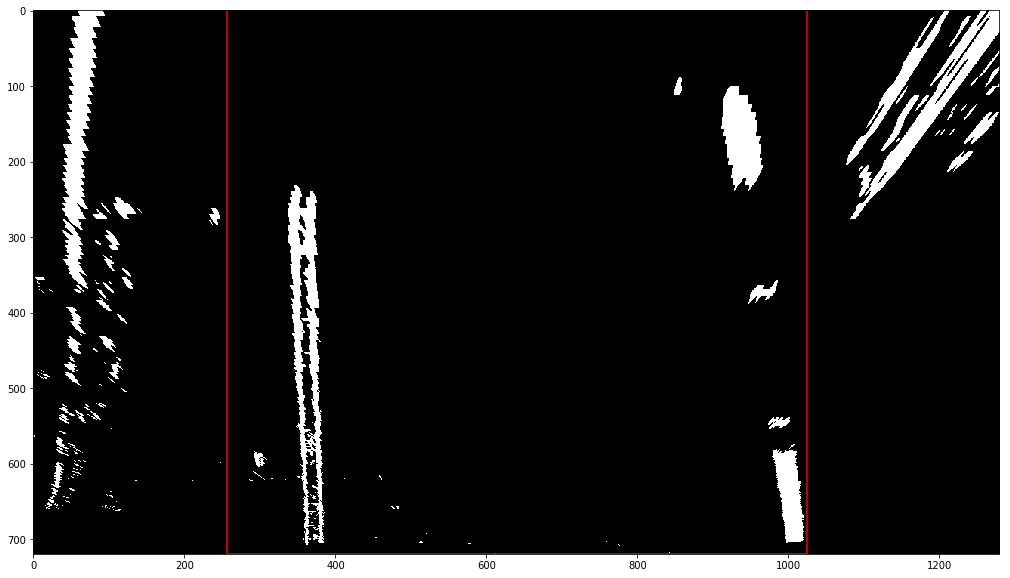

In [414]:
plt.figure(figsize=(20,10))
plt.plot(dst[:,0], dst[:,1], 'r-')
plt.imshow(warped,cmap='gray')
plt.show()

### Draw lane line

In [415]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [416]:
vertices = dst.astype(np.int32)
vertices.resize(1,4,2)
warped = region_of_interest(warped, vertices)


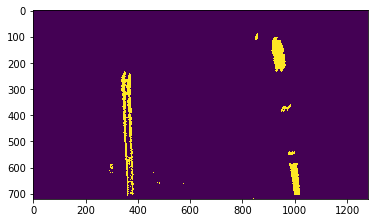

In [417]:
plt.imshow(warped)

In [418]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds =  ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        #pass # Remove this when you add your function
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty


In [419]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = (left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2])
    right_fitx = (right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2])
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty = find_lane_pixels(binary_warped)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy +  left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) +  left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy +  right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result,left_fit, right_fit

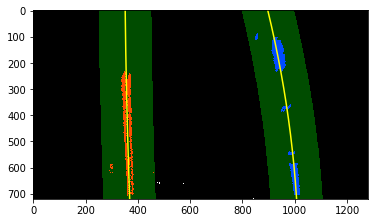

In [420]:
# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result,left_fit, right_fit = search_around_poly(warped)

# View your output
plt.imshow(result)

### Radius of curvature

In [338]:
def measure_curvature_pixels(left_fit, right_fit,y_eval):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    #y_eval = np.max(ploty)
    #y_eval = 720
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1+(2*left_fit[0]*y_eval+left_fit[1])**2)**1.5)/abs(2*left_fit[0])  ## Implement the calculation of the left line here
    right_curverad = ((1+(2*right_fit[0]*y_eval+right_fit[1])**2)**1.5)/abs(2*right_fit[0])  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad


In [339]:
y_eval = warped.shape[0]
left_curverad, right_curverad = measure_curvature_pixels(left_fit,right_fit,y_eval)

print(left_curverad, right_curverad)

2040.76665485 27887.2787301


In [340]:
def measure_curvature_real(left_fit_cr,right_fit_cr,y_eval):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    #y_eval = 720
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / abs(2*left_fit_cr[0])  ## Implement the calculation of the left line here
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / abs(2*right_fit_cr[0])  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad

In [341]:
# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real(left_fit,right_fit,y_eval)

print(left_curverad, 'm', right_curverad, 'm')

2023.80364609 m 27665.6911385 m


In [342]:
center = ( ( ( (left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]) +
            (right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]) )/2.0) - (warped.shape[1]/2.0))*3.7/700

### Draw lines

In [343]:
def draw_lines(undistorted,warped,Minv,radius,center,left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # And recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted.shape[1], undistorted.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)

    
    
    cv2.putText(result,'Radius of Curvature = {}(m)'.format(radius),(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

    if center < 0:
        text = 'left'
    else:
        text = 'right'
    cv2.putText(result,'Vehicle is {:.2f}m {} of center'.format(np.absolute(center), text),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    return result
    


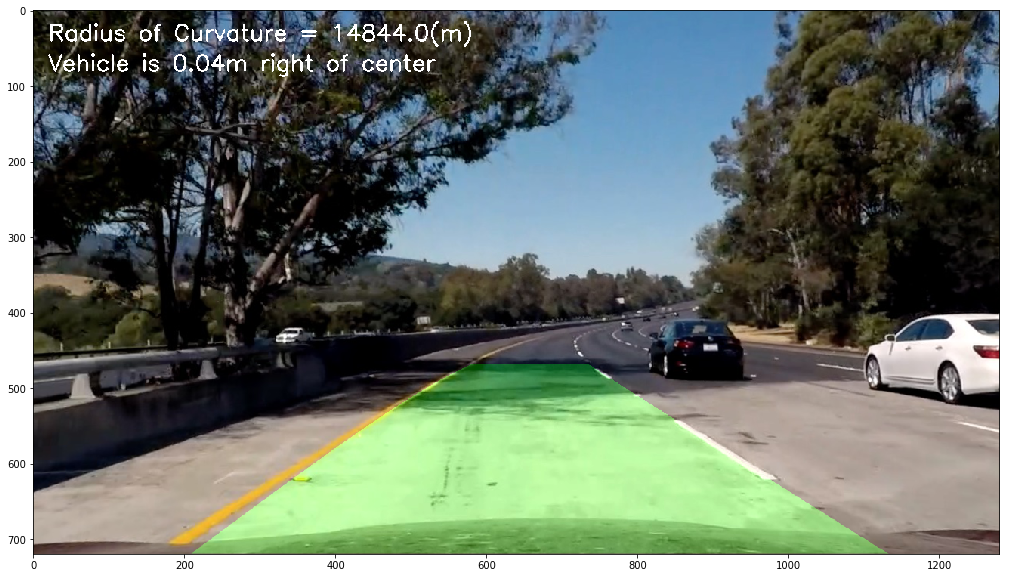

In [344]:
radius = (right_curverad+left_curverad)//2

final = draw_lines(undistorted,warped,Minv,radius,center,left_fit, right_fit)
plt.figure(figsize=(20,10))
plt.imshow(final)

## Pipeline (Video)

In [345]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [426]:
def process_image(img,mtx=mtx,dist=dist):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    #undistort
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    
    #binary image
    ksize=3
    gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=ksize, thresh=(25, 250))

    s_bin = hls_select(undistorted,thresh=(200,230))

    l_bin = hls_select(undistorted,thresh=(198,255),ch=1)

    combined = np.zeros_like(s_bin)

    combined[ (gradx == 1) | (s_bin == 1)| (l_bin == 1) ] = 1
    
    #src and  dest coord
    src = np.array([
        [img.shape[1] * 0.6, img.shape[0] * 0.65],
        [img.shape[1]*0.94, img.shape[0]],
        [img.shape[1]*0.09, img.shape[0]],
        [img.shape[1] * 0.44, img.shape[0] * 0.65],
    ],dtype='float32')

# Destination coordinates
    dst = np.array([
        [img.shape[1] * 0.8, 0],
        [img.shape[1] * 0.8, img.shape[0]],
        [img.shape[1] * 0.2, img.shape[0]],
        [img.shape[1] * 0.2, 0],
    ],dtype='float32')
    
    #unwarp
    warped,M,Minv = unwarp(combined,src,dst)
    
    
    #mask
    vertices = dst.astype(np.int32)
    vertices.resize(1,4,2)
    warped = region_of_interest(warped, vertices)
    #find lane px
    result,left_fit, right_fit = search_around_poly(warped)
    # Calculate the radius of curvature in meters for both lane lines
    y_eval = warped.shape[0]
    left_curverad, right_curverad = measure_curvature_real(left_fit,right_fit,y_eval)
    radius = (right_curverad+left_curverad)//2
    
    center = ( ( ( (left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]) +
            (right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]) )/2.0) - (warped.shape[1]/2.0))*3.7/700
    

    final = draw_lines(undistorted,warped,Minv,radius,center,left_fit, right_fit)
    return final
    
    
    
    

[MoviePy] >>>> Building video output_video/project_video.mp4
[MoviePy] Writing video output_video/project_video.mp4


100%|█████████▉| 1260/1261 [05:45<00:00,  3.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video.mp4 

CPU times: user 3min 24s, sys: 15.1 s, total: 3min 39s
Wall time: 5min 48s


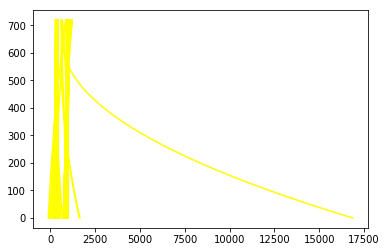

In [427]:
white_output = 'output_video/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [429]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))